In [144]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Lambda
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import metrics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import Counter
import tensorflow as tf

In [172]:
data = np.load('../data/fluxes_ecoli_biomass.npy')
rxns = np.load('../data/rxns_ecoli_but.npy')
data_no_nan = np.nan_to_num(x=data)
data.shape

(1258, 41, 2586)

In [173]:
flat_data = np.reshape(data_no_nan, (data.shape[0] * data.shape[1], data.shape[2]))

In [174]:
y = np.array(range(41) * data.shape[0])
y.shape

(51578,)

In [175]:
np.random.seed(seed=42)
train_ind = np.random.choice(flat_data.shape[0], size=int(0.9 * flat_data.shape[0]), replace=False)
test_ind = list(set(range(flat_data.shape[0])) - set(train_ind))

In [352]:
min_val = np.min(flat_data)
max_val = np.max(flat_data)
scale = lambda x: (x + abs(min_val)) / (abs(min_val) + max_val)
flat_data_scaled = scale(flat_data)

In [346]:
mn = np.mean(flat_data)
std = np.std(flat_data)
norm = lambda x: (x - mn) / std
flat_data_normed = norm(flat_data)

In [355]:
X_train, y_train = flat_data_scaled[train_ind], y[train_ind]
X_test, y_test = flat_data_scaled[test_ind], y[test_ind]

In [382]:
latent_dim = 3
epsilon_std = 1.0

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


def build_vae(X_shape, batch_size=100):
    encoded_dim1 = 1024
    encoded_sz = 256
    # Encoder network
    x = Input(shape=(X_shape,))
    h = Dense(encoded_dim1, activation='relu')(x)
    h = Dense(encoded_sz, activation='relu')(h)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)
    
    # Sample points from latent space
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    
    # Decoder network
    decoder_h = Dense(encoded_sz, activation='relu')
    decoder_h2 = Dense(encoded_dim1, activation='relu')
    decoder_mean = Dense(X_shape, activation='sigmoid')
    h_decoded = decoder_h(z)
    h_decoded2 = decoder_h2(h_decoded)
    x_decoded_mean = decoder_mean(h_decoded2)

    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)
    
    xent_loss = X_shape * metrics.mean_squared_error(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    #vae.summary()

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))
    _h_decoded = decoder_h(decoder_input)
    _h_decoded2 = decoder_h2(_h_decoded)
    _x_decoded_mean = decoder_mean(_h_decoded2)
    generator = Model(decoder_input, _x_decoded_mean)
    return vae, encoder, generator

In [383]:
batch_size = 256
vae, encoder, generator = build_vae(X_train.shape[1], batch_size)
es = EarlyStopping(patience=2)
vae.fit(X_train,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(X_test, None),
        callbacks=[es])

/Users/nlarusstone/.virtualenvs/mphil/lib/python2.7/site-packages/ipykernel_launcher.py:39: UserWarning: Output "dense_184" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_184" during training.


Train on 46420 samples, validate on 5158 samples
Epoch 1/10
46420/46420 [==============================] - 122s 3ms/step - loss: 3.9856 - val_loss: 0.2583
Epoch 2/10
46420/46420 [==============================] - 93s 2ms/step - loss: 0.2453 - val_loss: 0.2350
Epoch 3/10
46420/46420 [==============================] - 60s 1ms/step - loss: 0.2266 - val_loss: 0.2208
Epoch 4/10
46420/46420 [==============================] - 58s 1ms/step - loss: 0.2197 - val_loss: 0.2177
Epoch 5/10
46420/46420 [==============================] - 58s 1ms/step - loss: 0.2164 - val_loss: 0.2165
Epoch 6/10
46420/46420 [==============================] - 57s 1ms/step - loss: 0.2145 - val_loss: 0.2158
Epoch 7/10
46420/46420 [==============================] - 58s 1ms/step - loss: 0.2134 - val_loss: 0.2143
Epoch 8/10
46420/46420 [==============================] - 58s 1ms/step - loss: 0.2126 - val_loss: 0.2138
Epoch 9/10
46420/46420 [==============================] - 58s 1ms/step - loss: 0.2120 - val_loss: 0.2138
Epoch

In [384]:
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
x_test_encoded

array([[1.0993739e-05, 2.5342114e-04, 1.8781589e-04],
       [1.0993739e-05, 2.5342114e-04, 1.8781589e-04],
       [1.0993739e-05, 2.5342114e-04, 1.8781589e-04],
       ...,
       [1.0993739e-05, 2.5342114e-04, 1.8781589e-04],
       [1.0993739e-05, 2.5342102e-04, 1.8781594e-04],
       [1.0993739e-05, 2.5342102e-04, 1.8781594e-04]], dtype=float32)

In [387]:
np.std(x_test_encoded, axis=0)

array([3.4379508e-10, 9.0804404e-09, 1.5861275e-09], dtype=float32)

In [359]:
preds = generator.predict(x_test_encoded)
preds[0]

array([0.45933554, 0.4593587 , 0.4594071 , ..., 0.45931953, 0.45938182,
       0.459394  ], dtype=float32)

In [360]:
X_test[0]

array([0.4578113 , 0.4578113 , 0.45781122, ..., 0.45781122, 0.45781122,
       0.45781122])

In [361]:
mse = metrics.mse(y_pred=preds, y_true=X_test_scale)

In [362]:
s = tf.get_default_session()
K.set_session(session=s)
sess = K.get_session()
mns = mse.eval(session=sess)

In [363]:
mns

array([1.70036055, 1.70049099, 1.6992244 , ..., 1.70043739, 1.69860465,
       1.7003055 ])

In [218]:
def get_rct(df, rct, y_test):
    y_new = []
    for ind in y_test:
        y_new.append(df[rct][ind])
    return y_new
get_rct(df, 'Glucose', y_test)

[200,
 200,
 120,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 0,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 120,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 160,
 200,
 200,
 0,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 0,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 160,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 0,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 160,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 160,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 40,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 40,
 200,
 200,
 2

In [367]:
xmin, xmax, x_diff

(0.00266218, 0.00266218, 0.0)

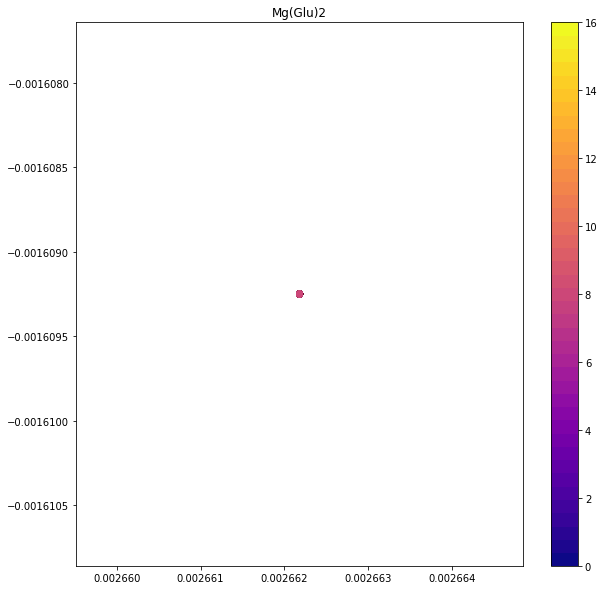

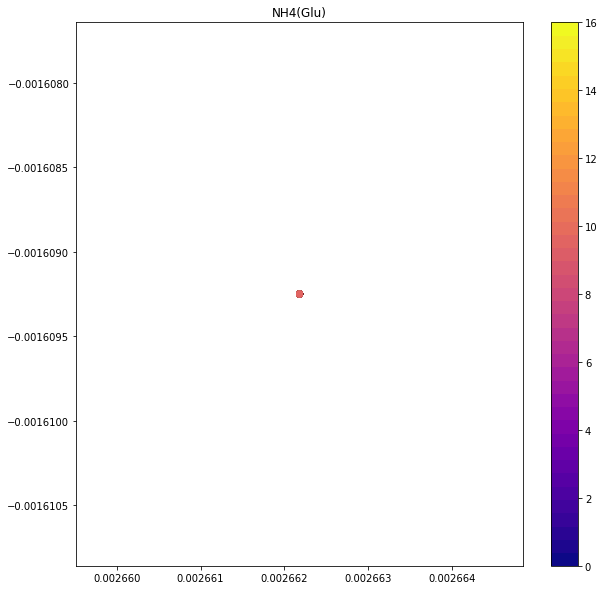

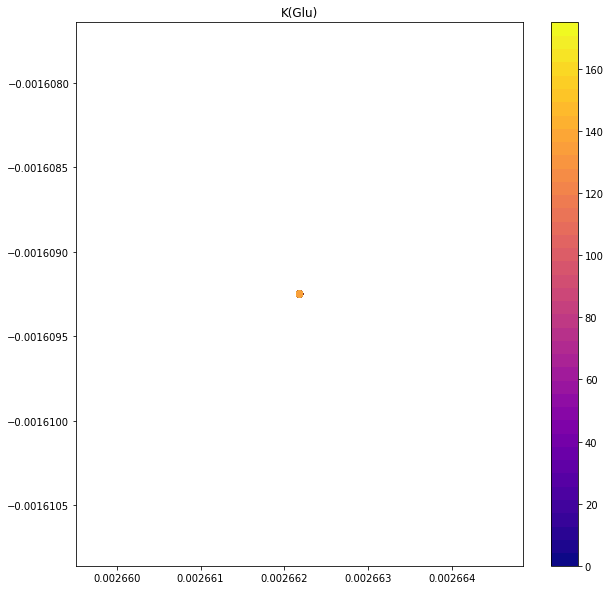

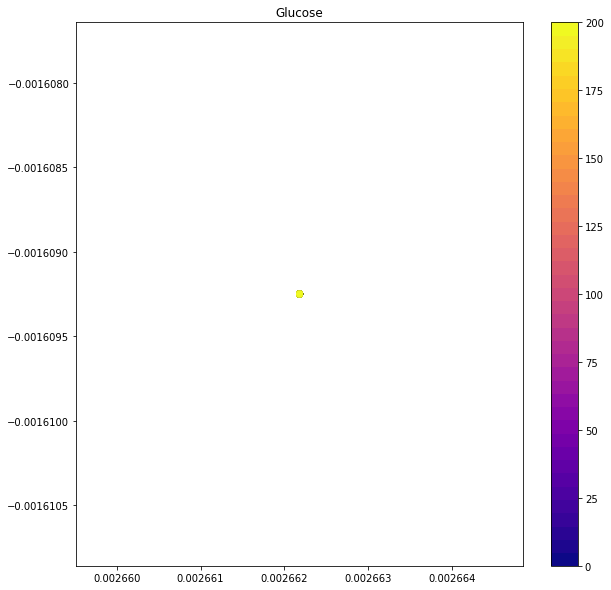

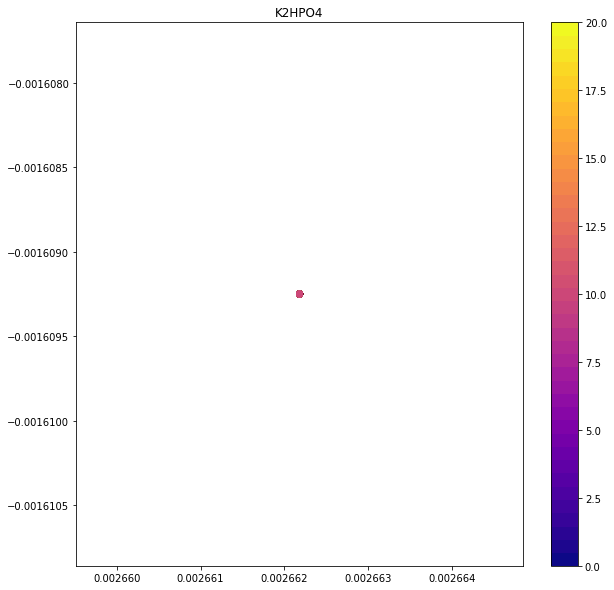

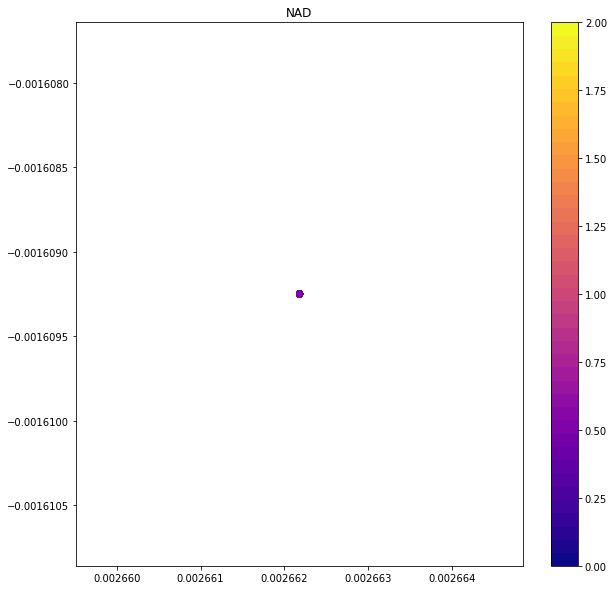

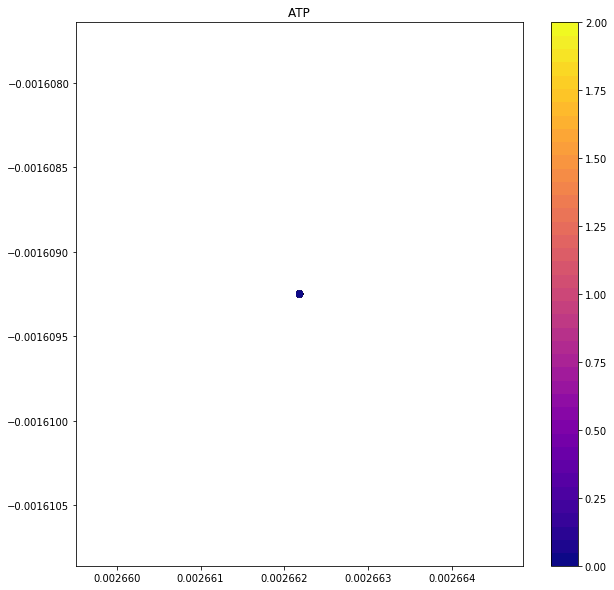

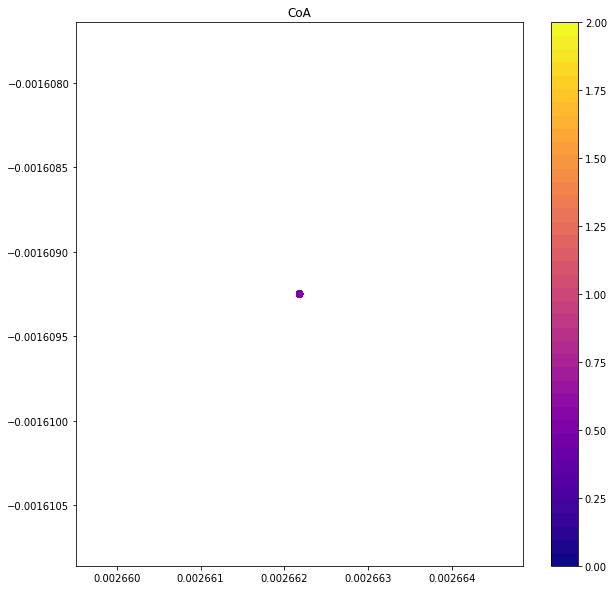

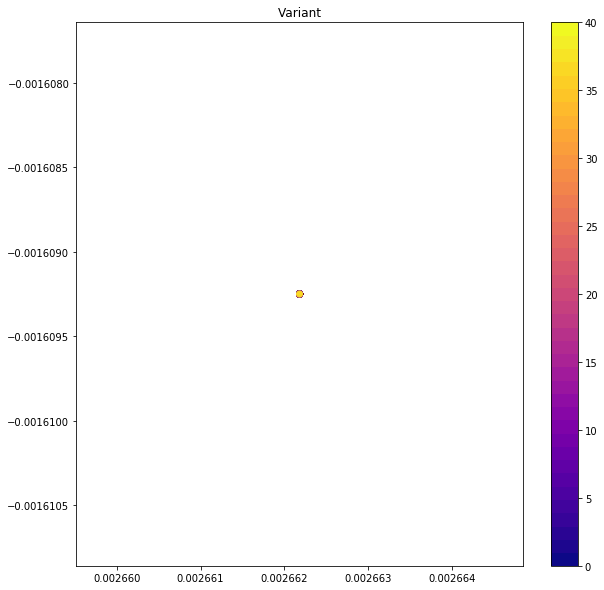

In [365]:
#cm1 = cm.get_cmap('tab20b', 20)
#cm2 = cm.get_cmap('tab20c', 20)
cmap = cm.get_cmap('plasma', 41)
#cmap = lambda x: cm1(x) if x < 21 else cm2(x)
xmin, xmax = np.amin(x_test_encoded[:, 0]), np.amax(x_test_encoded[:, 0])
ymin, ymax = np.amin(x_test_encoded[:, 1]), np.amax(x_test_encoded[:, 1])
x_diff = (xmax - xmin) / 10.0
y_diff = (ymax - ymin) / 10.0
for col in df.columns[4:]:
    plt.figure(figsize=(10, 10))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=get_rct(df, col, y_test), cmap=cmap)
    plt.xlim((xmin - x_diff, xmax + x_diff))
    plt.ylim((ymin - y_diff, ymax + y_diff))
    plt.title(col)
    plt.colorbar()
    plt.show()
    
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap=cmap)
plt.xlim((xmin - x_diff, xmax + x_diff))
plt.ylim((ymin - y_diff, ymax + y_diff))
plt.title('Variant')
plt.colorbar()
plt.show()

In [169]:
import pandas as pd
df = pd.read_csv('../data/Karim_MetEng_2018_Figure2_Data.csv')
df.drop(columns=['Area_1', 'Area_2', 'Conc_1', 'Conc_2'], inplace=True)
df.head()

,AVG,STD,AVG.1,STD.1,Mg(Glu)2,NH4(Glu),K(Glu),Glucose,K2HPO4,NAD,ATP,CoA
0,0.00,0.0,0.00,0.00,8.0,10.0,134,0,10,0.5,0.0,0.5
1,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.0,0.0,0.5
2,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.5,0.0,2.0
3,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.5,0.0,1.6
4,1.21,1.7,0.09,0.13,8.0,10.0,134,200,10,0.5,2.0,0.5


In [223]:
df.columns[3:]

Index([u'STD.1', u'Mg(Glu)2', u'NH4(Glu)', u'K(Glu)', u'Glucose', u'K2HPO4',
       u'NAD', u'ATP', u'CoA'],
      dtype='object')

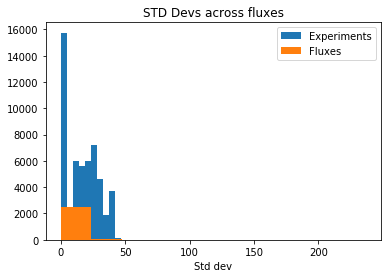

In [390]:
std_trials = np.std(flat_data, axis=1)
std_fluxes = np.std(flat_data, axis=0)
plt.hist(std_trials, label='Experiments')
plt.title('STD Devs across experiments')
plt.hist(std_fluxes, label='Fluxes')
plt.title('STD Devs across fluxes')
plt.xlabel('Std dev')
plt.legend()
plt.show()

In [393]:
sor_flux = np.argsort(std_fluxes)

In [394]:
sor_flux

array([1292, 1053, 1115, ...,  184, 1540,  749])